In [30]:
# --- Imports ---
import numpy as np
import cv2  # OpenCV is used for efficient image resizing
from datasets import load_dataset
from tqdm.notebook import tqdm  # Use the notebook-specific version of tqdm
import matplotlib.pyplot as plt

# --- Matplotlib Jupyter Magic Command ---
%matplotlib inline

# --- Configuration ---
# All images will be resized to this shape for consistent model input.
TARGET_SIZE = (256, 256)

In [31]:
def calculate_ndvi(msi_image):
    """
    Calculates the NDVI for a Sentinel-2 MSI image array.
    The input image is expected to have 13 channels.
    
    Args:
        msi_image (np.array): A NumPy array with shape (13, height, width).
        
    Returns:
        np.array: A 2D NumPy array with the calculated NDVI values.
    """
    # For Sentinel-2, Red is Band 4 (index 3) and NIR is Band 8 (index 7)
    red_band = msi_image[3, :, :].astype(float)
    nir_band = msi_image[7, :, :].astype(float)
    
    # Add a small epsilon to the denominator to prevent division by zero
    epsilon = 1e-10
    
    # Calculate NDVI
    ndvi = (nir_band - red_band) / (nir_band + red_band + epsilon)
    
    return ndvi

In [32]:
import numpy as np
import cv2
from datasets import load_dataset
from tqdm.notebook import tqdm
from PIL import Image
from io import BytesIO

print("Loading blanchon/OSCD_MSI dataset...")
# This dataset requires `trust_remote_code=True` because its loading script is hosted on the Hub.
dataset = load_dataset("blanchon/OSCD_MSI", trust_remote_code=True)
print("Dataset loaded.")

processed_data = {
    'image1': [],
    'image2': [],
    'ndvi_diff': [],
    'label_mask': []
}

for split in ['train', 'test']:
    print(f"\nProcessing '{split}' split...")
    
    # Access the underlying Apache Arrow tables directly to bypass faulty metadata
    image1_table = dataset[split].data.column('image1')
    image2_table = dataset[split].data.column('image2')
    # --- FIX IS HERE: Changed 'label' back to the correct column name 'mask' ---
    mask_table = dataset[split].data.column('mask') 
    
    num_samples = len(dataset[split])
    
    for i in tqdm(range(num_samples), desc=f"Processing {split} samples"):
        image1_raw = np.array(image1_table[i].as_py())
        image2_raw = np.array(image2_table[i].as_py())
        mask_data_unprocessed = mask_table[i].as_py()
        
        try:
            # First, try to treat the mask as a NumPy array (the normal case)
            mask_raw = np.array(mask_data_unprocessed)
            if mask_raw.ndim == 0 and isinstance(mask_raw.item(), dict):
                 # This handles cases where a dictionary is wrapped in a 0-dim array
                 mask_data_unprocessed = mask_raw.item()
                 raise TypeError("Contained a dictionary")
            
        except (TypeError, ValueError):
            # If the above fails, it's likely a dictionary containing image bytes.
            if isinstance(mask_data_unprocessed, dict):
                if 'bytes' in mask_data_unprocessed and mask_data_unprocessed['bytes'] is not None:
                    try:
                        mask_image = Image.open(BytesIO(mask_data_unprocessed['bytes']))
                        mask_raw = np.array(mask_image)
                    except Exception as e:
                        print(f"\nERROR: Could not decode bytes for mask at index {i}. {e}. Skipping sample.")
                        continue
                else:
                    print(f"\nERROR: Mask dictionary at index {i} does not contain usable 'bytes'. Skipping sample.")
                    continue
            else:
                print(f"\nERROR: Unhandled data type for mask at index {i}: {type(mask_data_unprocessed)}. Skipping sample.")
                continue

        # --- Resuming Normal Processing ---
        image1_resized = cv2.resize(
            image1_raw.transpose(1, 2, 0).astype(np.float32), 
            TARGET_SIZE, 
            interpolation=cv2.INTER_LINEAR
        ).transpose(2, 0, 1)
        
        image2_resized = cv2.resize(
            image2_raw.transpose(1, 2, 0).astype(np.float32), 
            TARGET_SIZE, 
            interpolation=cv2.INTER_LINEAR
        ).transpose(2, 0, 1)

        mask_resized = cv2.resize(
            mask_raw.astype(np.uint8), 
            TARGET_SIZE, 
            interpolation=cv2.INTER_NEAREST
        )

        ndvi_before = calculate_ndvi(image1_resized)
        ndvi_after = calculate_ndvi(image2_resized)
        ndvi_difference = ndvi_after - ndvi_before
        
        processed_data['image1'].append(image1_resized)
        processed_data['image2'].append(image2_resized)
        processed_data['ndvi_diff'].append(ndvi_difference)
        processed_data['label_mask'].append(mask_resized)

print("\nConverting lists to final NumPy arrays...")
final_arrays = {key: np.stack(value, axis=0) for key, value in processed_data.items()}

print("\n--- Processing Complete! ---")

Loading blanchon/OSCD_MSI dataset...
Dataset loaded.

Processing 'train' split...


Processing train samples:   0%|          | 0/14 [00:00<?, ?it/s]


Processing 'test' split...


Processing test samples:   0%|          | 0/10 [00:00<?, ?it/s]


Converting lists to final NumPy arrays...

--- Processing Complete! ---


In [33]:
# This cell verifies the output of the long processing step above.
# It prints the shape and data type of each array you created.
print("--- Verification of Final Arrays ---")
print("Final array shapes:")
for name, arr in final_arrays.items():
    print(f"  - {name}: {arr.shape}, dtype: {arr.dtype}")

--- Verification of Final Arrays ---
Final array shapes:
  - image1: (24, 13, 256, 256), dtype: float32
  - image2: (24, 13, 256, 256), dtype: float32
  - ndvi_diff: (24, 256, 256), dtype: float64
  - label_mask: (24, 256, 256), dtype: uint8


In [34]:
def create_false_color_composite(msi_image):
    """Creates a 3-channel false-color image from a 13-channel Sentinel-2 array."""
    # Bands for false-color composite (NIR, Red, Green) -> (B8, B4, B3)
    # Bands are 0-indexed, so B8 is index 7, B4 is index 3, B3 is index 2.
    nir_band = msi_image[7, :, :]
    red_band = msi_image[3, :, :]
    green_band = msi_image[2, :, :]
    
    # Stack them into a 3-channel image for plotting
    false_color_image = np.stack([nir_band, red_band, green_band], axis=-1)
    
    # Normalize for display
    vmax = np.percentile(false_color_image, 98)
    false_color_image = np.clip(false_color_image / (vmax + 1e-10), 0, 1)
    return false_color_image

# Choose a sample index to display (e.g., 10 is a good one with visible change)
sample_index = 10 

# Get the data for the chosen sample from your final processed arrays
img1 = final_arrays['image1'][sample_index]
img2 = final_arrays['image2'][sample_index]
ndvi_diff = final_arrays['ndvi_diff'][sample_index]
mask = final_arrays['label_mask'][sample_index]

# Create false-color composites for visualization
img1_display = create_false_color_composite(img1)
img2_display = create_false_color_composite(img2)

# Plot everything
fig, axes = plt.subplots(1, 4, figsize=(24, 6))

axes[0].imshow(img1_display)
axes[0].set_title('Image Before (False Color)')
axes[0].axis('off')

axes[1].imshow(img2_display)
axes[1].set_title('Image After (False Color)')
axes[1].axis('off')

im = axes[2].imshow(ndvi_diff, cmap='RdBu', vmin=-0.5, vmax=0.5)
axes[2].set_title('NDVI Difference')
axes[2].axis('off')
fig.colorbar(im, ax=axes[2], orientation='horizontal', pad=0.05)

axes[3].imshow(mask, cmap='gray')
axes[3].set_title('Ground Truth Change Mask')
axes[3].axis('off')

plt.tight_layout()
plt.show()

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

print("Reshaping data for Random Forest...")

# Stack the 'before' image, 'after' image, and NDVI difference to create the features
ndvi_diff_expanded = np.expand_dims(final_arrays['ndvi_diff'], axis=1)
feature_stack = np.concatenate([final_arrays['image1'], final_arrays['image2'], ndvi_diff_expanded], axis=1)

# Transpose and reshape to create the final feature matrix (X)
X_transposed = feature_stack.transpose(0, 2, 3, 1) 
num_images, height, width, num_features = X_transposed.shape
X_pixel_features = X_transposed.reshape(-1, num_features)

# Flatten the label mask to create the target vector (y)
y_pixel_labels = final_arrays['label_mask'].flatten()

# --- Create the Train/Test Split ---
num_train_images = 14
pixels_per_image = TARGET_SIZE[0] * TARGET_SIZE[1]
split_index = num_train_images * pixels_per_image

X_train_full = X_pixel_features[:split_index]
y_train_full = y_pixel_labels[:split_index]

X_test = X_pixel_features[split_index:]
y_test = y_pixel_labels[split_index:]

# --- Subsample for faster training ---
sample_size = 100000
np.random.seed(42) # for reproducibility
random_indices = np.random.choice(len(X_train_full), size=sample_size, replace=False)

X_train_sampled = X_train_full[random_indices]
y_train_sampled = y_train_full[random_indices]

print(f"Using {len(X_train_sampled)} pixels for training.")
print(f"Using {len(X_test)} pixels for testing.")

Reshaping data for Random Forest...
Using 100000 pixels for training.
Using 655360 pixels for testing.


In [36]:
# Initialize the model with recommended parameters
rf_model = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    n_jobs=-1,              # Use all available CPU cores
    class_weight='balanced' # Important for imbalanced data
)

print("Training Random Forest model...")

# Train the model completely on the sampled training data
rf_model.fit(X_train_sampled, y_train_sampled)

print("Model training complete.")

Training Random Forest model...
Model training complete.


In [37]:
print("Evaluating model on the unseen test set...")

# Predict on the entire test set (all pixels from the 10 test images)
y_pred = rf_model.predict(X_test)

# --- Calculate and Print Metrics ---
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy on Test Set: {accuracy:.4f}\n")

# Print a detailed classification report with precision, recall, and F1-score
print("Classification Report for Test Set:")
print(classification_report(y_test, y_pred, target_names=['No Change (0)', 'Change (1)']))

# --- Display Confusion Matrix ---
print("\nDisplaying Confusion Matrix...")
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    y_test, 
    y_pred, 
    ax=ax, 
    display_labels=['No Change', 'Change'],
    cmap='Blues'
)
ax.set_title('Confusion Matrix for Test Set')
plt.show()

Evaluating model on the unseen test set...
Overall Accuracy on Test Set: 0.9564

Classification Report for Test Set:
               precision    recall  f1-score   support

No Change (0)       0.96      1.00      0.98    626777
   Change (1)       0.50      0.02      0.04     28583

     accuracy                           0.96    655360
    macro avg       0.73      0.51      0.51    655360
 weighted avg       0.94      0.96      0.94    655360


Displaying Confusion Matrix...


In [38]:
# We'll need the false-color composite function again for visualization
def create_false_color_composite(msi_image):
    """Creates a 3-channel false-color image from a 13-channel Sentinel-2 array."""
    nir_band = msi_image[7, :, :]
    red_band = msi_image[3, :, :]
    green_band = msi_image[2, :, :]
    false_color_image = np.stack([nir_band, red_band, green_band], axis=-1)
    vmax = np.percentile(false_color_image, 98)
    false_color_image = np.clip(false_color_image / (vmax + 1e-10), 0, 1)
    return false_color_image

# Let's visualize the prediction for the first test image
test_image_index = 0
image_display_index = num_train_images + test_image_index

# Get the pixels for just this one test image
start = test_image_index * pixels_per_image
end = start + pixels_per_image
y_pred_mask_flat = y_pred[start:end] # Use the predictions we already made

# Reshape the flat predictions back to a 2D image mask
predicted_mask = y_pred_mask_flat.reshape(TARGET_SIZE)
true_mask = y_test[start:end].reshape(TARGET_SIZE)

# --- Plotting ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
image_to_display = create_false_color_composite(final_arrays['image2'][image_display_index])

axes[0].imshow(image_to_display)
axes[0].set_title(f'Test Image #{test_image_index} (False Color)')
axes[0].axis('off')

axes[1].imshow(true_mask, cmap='gray')
axes[1].set_title('True Mask')
axes[1].axis('off')

axes[2].imshow(predicted_mask, cmap='gray')
axes[2].set_title('Predicted Mask (Random Forest)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [39]:
# Run this command in your terminal or in a notebook cell with a "!" prefix
!pip install -q segmentation-models-pytorch

In [40]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import numpy as np

# --- Recreate the train/test split at the image level ---
num_train_images = 14
X_input = np.concatenate([final_arrays['image1'], final_arrays['image2']], axis=1)
y_input = np.expand_dims(final_arrays['label_mask'], axis=1)

X_train = X_input[:num_train_images]
y_train = y_input[:num_train_images]
X_test = X_input[num_train_images:]
y_test = y_input[num_train_images:]

# --- PyTorch Custom Dataset ---
class ChangeDetectionDataset(Dataset):
    def __init__(self, X, y):
        self.X = X.astype(np.float32)
        self.y = y.astype(np.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]), torch.from_numpy(self.y[idx])

train_dataset = ChangeDetectionDataset(X_train, y_train)
test_dataset = ChangeDetectionDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

print("PyTorch DataLoaders created.")

PyTorch DataLoaders created.


In [44]:
# --- Model Definition ---
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=26,
    classes=1,
)

# --- Training Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

print("Starting U-Net training with test evaluation each epoch...")
# --- Training Loop ---
num_epochs = 15

for epoch in range(num_epochs):
    # --- TRAINING PHASE ---
    model.train() # Set the model to training mode
    
    train_loss = 0
    train_correct_pixels = 0
    train_total_pixels = 0
    
    # Use tqdm for a nice progress bar on the training data
    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(inputs)
        
        # Calculate loss
        loss = criterion(outputs, targets)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

        # Calculate training accuracy
        with torch.no_grad():
            preds = (torch.sigmoid(outputs) > 0.5).float()
            train_correct_pixels += (preds == targets).sum().item()
            train_total_pixels += targets.numel()

    # --- VALIDATION/TESTING PHASE ---
    model.eval() # Set the model to evaluation mode
    
    test_loss = 0
    test_correct_pixels = 0
    test_total_pixels = 0
    
    with torch.no_grad(): # Disable gradient calculations
        for inputs, targets in tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Test]"):
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            # Forward pass
            outputs = model(inputs)
            
            # Calculate loss
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            
            # Calculate test accuracy
            preds = (torch.sigmoid(outputs) > 0.5).float()
            test_correct_pixels += (preds == targets).sum().item()
            test_total_pixels += targets.numel()

    # --- EPOCH SUMMARY ---
    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = (train_correct_pixels / train_total_pixels) * 100
    
    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = (test_correct_pixels / test_total_pixels) * 100
    
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}% | "
          f"Test Loss: {avg_test_loss:.4f}, Test Acc: {test_accuracy:.2f}%")

print("\nU-Net training complete.")

Starting U-Net training with test evaluation each epoch...


Epoch 1/15 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/15 [Test]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/15 | Train Loss: 0.6629, Train Acc: 61.72% | Test Loss: 0.7673, Test Acc: 43.41%


Epoch 2/15 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2/15 [Test]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2/15 | Train Loss: 0.6395, Train Acc: 64.84% | Test Loss: 0.7089, Test Acc: 51.92%


Epoch 3/15 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3/15 [Test]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 3/15 | Train Loss: 0.6148, Train Acc: 68.66% | Test Loss: 0.6907, Test Acc: 55.33%


Epoch 4/15 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4/15 [Test]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 4/15 | Train Loss: 0.5888, Train Acc: 73.75% | Test Loss: 0.6637, Test Acc: 61.01%


Epoch 5/15 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5/15 [Test]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 5/15 | Train Loss: 0.5667, Train Acc: 78.05% | Test Loss: 0.6303, Test Acc: 67.20%


Epoch 6/15 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6/15 [Test]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 6/15 | Train Loss: 0.5499, Train Acc: 81.59% | Test Loss: 0.6006, Test Acc: 73.01%


Epoch 7/15 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7/15 [Test]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 7/15 | Train Loss: 0.5296, Train Acc: 85.58% | Test Loss: 0.5655, Test Acc: 80.84%


Epoch 8/15 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8/15 [Test]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 8/15 | Train Loss: 0.5107, Train Acc: 89.63% | Test Loss: 0.5291, Test Acc: 87.83%


Epoch 9/15 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9/15 [Test]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 9/15 | Train Loss: 0.4961, Train Acc: 91.84% | Test Loss: 0.5005, Test Acc: 91.18%


Epoch 10/15 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10/15 [Test]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10/15 | Train Loss: 0.4818, Train Acc: 93.44% | Test Loss: 0.4815, Test Acc: 92.77%


Epoch 11/15 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11/15 [Test]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11/15 | Train Loss: 0.4695, Train Acc: 94.95% | Test Loss: 0.4660, Test Acc: 93.76%


Epoch 12/15 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12/15 [Test]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12/15 | Train Loss: 0.4543, Train Acc: 96.18% | Test Loss: 0.4645, Test Acc: 94.39%


Epoch 13/15 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13/15 [Test]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 13/15 | Train Loss: 0.4403, Train Acc: 96.98% | Test Loss: 0.4629, Test Acc: 94.84%


Epoch 14/15 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14/15 [Test]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 14/15 | Train Loss: 0.4300, Train Acc: 97.22% | Test Loss: 0.4550, Test Acc: 95.17%


Epoch 15/15 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15/15 [Test]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 15/15 | Train Loss: 0.4181, Train Acc: 97.48% | Test Loss: 0.4485, Test Acc: 95.32%

U-Net training complete.


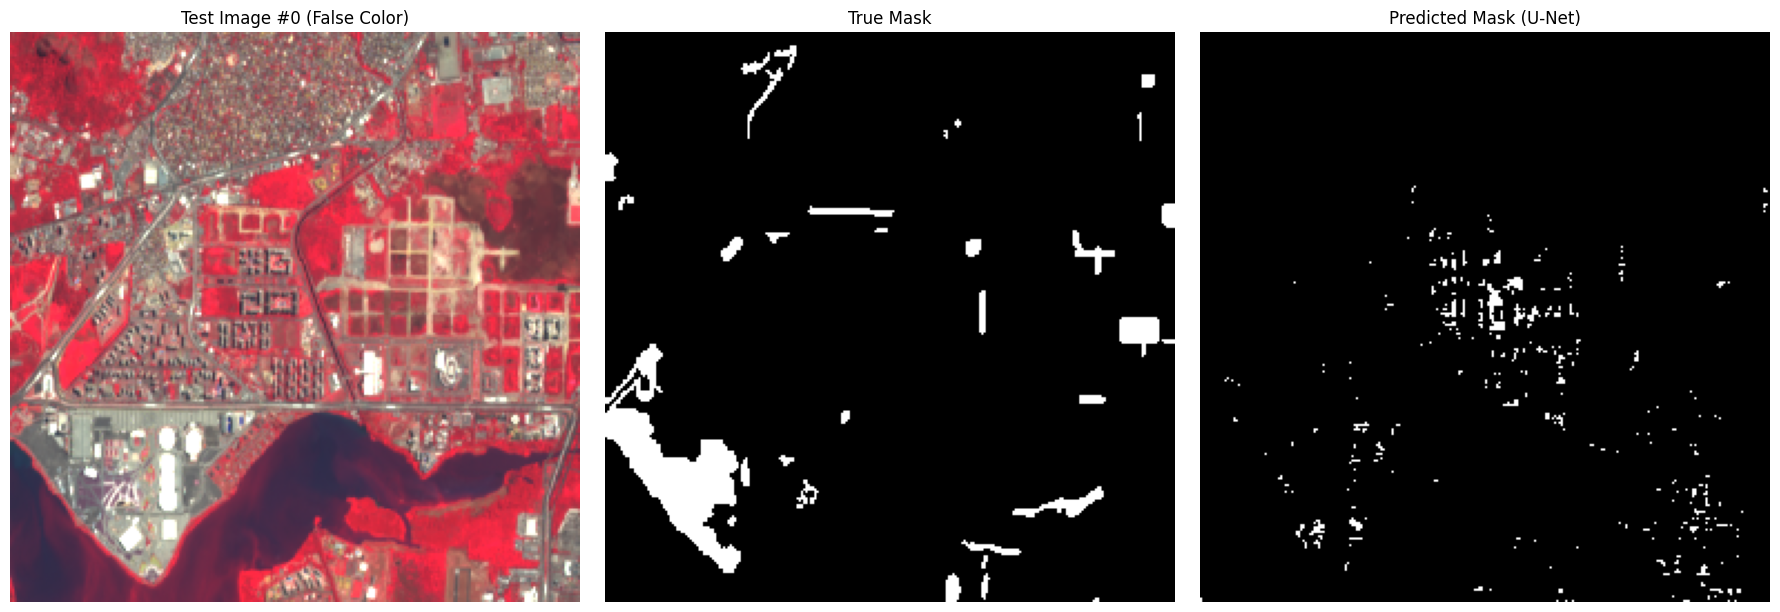

In [45]:
# --- Visualization ---
model.eval()
with torch.no_grad():
    # Get a single image from the test set
    test_image_index = 0
    input_tensor, true_mask_tensor = test_dataset[test_image_index]
    
    # Add a batch dimension and send to device
    input_tensor = input_tensor.unsqueeze(0).to(device)
    
    # Get model prediction
    pred_logits = model(input_tensor)
    
    # Convert logits to probabilities (0-1) and then to a binary mask (0 or 1)
    pred_prob = torch.sigmoid(pred_logits)
    pred_mask = (pred_prob > 0.5).float()
    
    # Move tensors to CPU and convert to numpy for plotting
    pred_mask_np = pred_mask.squeeze().cpu().numpy()
    true_mask_np = true_mask_tensor.squeeze().cpu().numpy()
    
    # We need the original image to display
    # The test set starts at index 14 in the original final_arrays
    image_display = create_false_color_composite(final_arrays['image2'][num_train_images + test_image_index])
    
    # --- Plotting ---
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].imshow(image_display)
    axes[0].set_title(f'Test Image #{test_image_index} (False Color)')
    axes[0].axis('off')

    axes[1].imshow(true_mask_np, cmap='gray')
    axes[1].set_title('True Mask')
    axes[1].axis('off')

    axes[2].imshow(pred_mask_np, cmap='gray')
    axes[2].set_title('Predicted Mask (U-Net)')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

In [55]:
# Install the KaggleHub client
!pip install -q kagglehub

In [59]:
# Install the KaggleHub client
!pip install -q kagglehub

import kagglehub
import os

# This will re-confirm the download path.
print("Confirming LEVIR-CD dataset path via KaggleHub...")
path = kagglehub.dataset_download("mdrifaturrahman33/levir-cd")

print(f"\nDataset download complete at: {path}")

# --- THE FINAL, CORRECT PATH DEFINITION ---
# We now correctly point to the subfolder named 'LEVIR CD'
DATA_PATH = os.path.join(path, 'LEVIR CD') 
print(f"Correct base path for processing: {DATA_PATH}")

Confirming LEVIR-CD dataset path via KaggleHub...

Dataset download complete at: /kaggle/input/levir-cd
Correct base path for processing: /kaggle/input/levir-cd/LEVIR CD


In [60]:
import numpy as np
import cv2
from glob import glob
from tqdm.notebook import tqdm
import os

# --- Configuration (remains the same) ---
TARGET_SIZE = (256, 256)

# --- Main Processing Logic ---
# This uses the CORRECT DATA_PATH defined in the cell above
processed_data = {
    'image1': [],
    'image2': [],
    'label_mask': []
}

for split in ['train', 'val', 'test']:
    image1_folder_path = os.path.join(DATA_PATH, split, 'A')
    
    if not os.path.isdir(image1_folder_path):
        print(f"--> WARNING: Directory not found, skipping: {image1_folder_path}")
        continue
        
    print(f"\nProcessing '{split}' split from: {image1_folder_path}")
    
    image1_paths = sorted(glob(os.path.join(image1_folder_path, '*.png')))
    
    if len(image1_paths) == 0:
        print(f"--> WARNING: No images found in {image1_folder_path}")
        continue
    
    for path1 in tqdm(image1_paths, desc=f"Processing {split} samples"):
        path2 = path1.replace('/A/', '/B/')
        mask_path = path1.replace('/A/', '/label/')
        
        if not (os.path.exists(path2) and os.path.exists(mask_path)):
            print(f"--> WARNING: Missing corresponding file for {path1}. Skipping.")
            continue
            
        image1_bgr = cv2.imread(path1)
        image2_bgr = cv2.imread(path2)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        image1_rgb = cv2.cvtColor(image1_bgr, cv2.COLOR_BGR2RGB)
        image2_rgb = cv2.cvtColor(image2_bgr, cv2.COLOR_BGR2RGB)
        
        image1_resized = cv2.resize(image1_rgb, TARGET_SIZE, interpolation=cv2.INTER_LINEAR)
        image2_resized = cv2.resize(image2_rgb, TARGET_SIZE, interpolation=cv2.INTER_LINEAR)
        mask_resized = cv2.resize(mask, TARGET_SIZE, interpolation=cv2.INTER_NEAREST)
        
        image1_norm = image1_resized / 255.0
        image2_norm = image2_resized / 255.0
        
        _, mask_binary = cv2.threshold(mask_resized, 127, 255, cv2.THRESH_BINARY)
        mask_norm = mask_binary / 255.0
        
        processed_data['image1'].append(image1_norm.transpose(2, 0, 1))
        processed_data['image2'].append(image2_norm.transpose(2, 0, 1))
        processed_data['label_mask'].append(mask_norm)

# Convert lists to final NumPy arrays
print("\nConverting lists to final NumPy arrays...")
final_arrays = {key: np.array(value, dtype=np.float32) if key != 'label_mask' else np.array(value, dtype=np.uint8) for key, value in processed_data.items()}

print("\n--- Processing Complete! ---")
# --- Verification Step ---
print("Final array shapes:")
for name, arr in final_arrays.items():
    print(f"  - {name}: {arr.shape}, dtype: {arr.dtype}")


Processing 'train' split from: /kaggle/input/levir-cd/LEVIR CD/train/A


Processing train samples:   0%|          | 0/445 [00:00<?, ?it/s]


Processing 'val' split from: /kaggle/input/levir-cd/LEVIR CD/val/A


Processing val samples:   0%|          | 0/64 [00:00<?, ?it/s]


Processing 'test' split from: /kaggle/input/levir-cd/LEVIR CD/test/A


Processing test samples:   0%|          | 0/128 [00:00<?, ?it/s]


Converting lists to final NumPy arrays...

--- Processing Complete! ---
Final array shapes:
  - image1: (637, 3, 256, 256), dtype: float32
  - image2: (637, 3, 256, 256), dtype: float32
  - label_mask: (637, 256, 256), dtype: uint8


In [61]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import albumentations as A
import numpy as np
import os
from glob import glob

# --- 1. Define Augmentation Pipeline ---
# These random transformations make our model more robust.
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
])


# --- 2. PyTorch Custom Dataset ---
class ChangeDetectionDataset(Dataset):
    def __init__(self, images1, images2, masks, augmentations=None):
        self.images1 = images1.astype(np.float32)
        self.images2 = images2.astype(np.float32)
        self.masks = masks.astype(np.float32)
        self.augmentations = augmentations

    def __len__(self):
        return len(self.images1)

    def __getitem__(self, idx):
        img1, img2, mask = self.images1[idx], self.images2[idx], self.masks[idx]
        
        # The input to the model will be the stacked images
        image_stack = np.concatenate([img1, img2], axis=0) # Shape: (6, 256, 256)

        if self.augmentations:
            # Transpose to (H, W, C) for albumentations
            augmented = self.augmentations(image=image_stack.transpose(1, 2, 0), mask=mask)
            image_stack = augmented['image'].transpose(2, 0, 1) # Transpose back
            mask = augmented['mask']
        
        # Return as PyTorch Tensors, adding a "channel" dimension to the mask
        return torch.from_numpy(image_stack), torch.from_numpy(mask).unsqueeze(0)

# --- 3. Create Train/Val/Test Splits ---
# We use the original splits provided by the dataset creators
DATA_PATH = '/kaggle/input/levir-cd/LEVIR CD' # As determined previously
train_len = len(glob(os.path.join(DATA_PATH, 'train', 'A', '*.png')))
val_len = len(glob(os.path.join(DATA_PATH, 'val', 'A', '*.png')))

X1_all = final_arrays['image1']
X2_all = final_arrays['image2']
y_all = final_arrays['label_mask']

# Create the datasets with and without augmentations
train_dataset = ChangeDetectionDataset(X1_all[:train_len], X2_all[:train_len], y_all[:train_len], augmentations=train_transform)
val_dataset = ChangeDetectionDataset(X1_all[train_len:train_len+val_len], X2_all[train_len:train_len+val_len], y_all[train_len:train_len+val_len])
test_dataset = ChangeDetectionDataset(X1_all[train_len+val_len:], X2_all[train_len+val_len:], y_all[train_len+val_len:])

# --- 4. Create DataLoaders ---
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

print(f"DataLoaders created successfully:")
print(f"  - {len(train_dataset)} training images")
print(f"  - {len(val_dataset)} validation images")
print(f"  - {len(test_dataset)} testing images")

DataLoaders created successfully:
  - 445 training images
  - 64 validation images
  - 128 testing images


In [64]:
import segmentation_models_pytorch as smp
from tqdm.notebook import tqdm
import torch
import torch.nn as nn

# --- Model Definition ---
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=6,
    classes=1,
)

# --- Training Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Use a combined loss for better segmentation performance
loss1 = smp.losses.DiceLoss(mode='binary')
loss2 = nn.BCEWithLogitsLoss()
criterion = lambda pred, target: 0.5 * loss1(pred, target) + 0.5 * loss2(pred, target)

# Variables for saving the best model
best_val_loss = float('inf')
num_epochs = 15

print("Starting U-Net training with validation and accuracy metrics...")
for epoch in range(num_epochs):
    # --- TRAINING PHASE ---
    model.train()
    train_loss = 0
    # --- Added for accuracy ---
    train_correct_pixels = 0
    train_total_pixels = 0
    
    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        # --- Added for accuracy ---
        with torch.no_grad():
            preds = (torch.sigmoid(outputs) > 0.5).float()
            train_correct_pixels += (preds == targets).sum().item()
            train_total_pixels += targets.numel()
        
    # --- VALIDATION PHASE ---
    model.eval()
    val_loss = 0
    # --- Added for accuracy ---
    val_correct_pixels = 0
    val_total_pixels = 0
    
    with torch.no_grad():
        for inputs, targets in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            
            # --- Added for accuracy ---
            preds = (torch.sigmoid(outputs) > 0.5).float()
            val_correct_pixels += (preds == targets).sum().item()
            val_total_pixels += targets.numel()
            
    # --- EPOCH SUMMARY ---
    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = (train_correct_pixels / train_total_pixels) * 100
    
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = (val_correct_pixels / val_total_pixels) * 100
    
    print(
        f"Epoch {epoch+1}/{num_epochs} | "
        f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}% | "
        f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%"
    )

    # --- Save the best model ---
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print("  -> Model saved (new best validation loss)")

print("\nU-Net training complete.")

Starting U-Net training with validation and accuracy metrics...


Epoch 1/15 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 1/15 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/15 | Train Loss: 0.7673, Train Acc: 70.46% | Val Loss: 1.0509, Val Acc: 69.67%
  -> Model saved (new best validation loss)


Epoch 2/15 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 2/15 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2/15 | Train Loss: 0.6754, Train Acc: 90.00% | Val Loss: 0.6556, Val Acc: 93.43%
  -> Model saved (new best validation loss)


Epoch 3/15 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 3/15 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3/15 | Train Loss: 0.6149, Train Acc: 93.64% | Val Loss: 0.5990, Val Acc: 94.29%
  -> Model saved (new best validation loss)


Epoch 4/15 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 4/15 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4/15 | Train Loss: 0.5781, Train Acc: 92.66% | Val Loss: 0.5692, Val Acc: 93.09%
  -> Model saved (new best validation loss)


Epoch 5/15 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 5/15 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5/15 | Train Loss: 0.5500, Train Acc: 92.97% | Val Loss: 0.5400, Val Acc: 93.09%
  -> Model saved (new best validation loss)


Epoch 6/15 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 6/15 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6/15 | Train Loss: 0.5178, Train Acc: 93.80% | Val Loss: 0.5151, Val Acc: 95.50%
  -> Model saved (new best validation loss)


Epoch 7/15 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 7/15 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7/15 | Train Loss: 0.4914, Train Acc: 94.35% | Val Loss: 0.4872, Val Acc: 95.90%
  -> Model saved (new best validation loss)


Epoch 8/15 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 8/15 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8/15 | Train Loss: 0.4700, Train Acc: 94.76% | Val Loss: 0.4750, Val Acc: 94.10%
  -> Model saved (new best validation loss)


Epoch 9/15 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 9/15 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9/15 | Train Loss: 0.4490, Train Acc: 94.93% | Val Loss: 0.4431, Val Acc: 95.15%
  -> Model saved (new best validation loss)


Epoch 10/15 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 10/15 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10/15 | Train Loss: 0.4270, Train Acc: 95.41% | Val Loss: 0.4344, Val Acc: 95.32%
  -> Model saved (new best validation loss)


Epoch 11/15 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 11/15 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11/15 | Train Loss: 0.4067, Train Acc: 95.64% | Val Loss: 0.4032, Val Acc: 96.23%
  -> Model saved (new best validation loss)


Epoch 12/15 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 12/15 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12/15 | Train Loss: 0.3891, Train Acc: 95.91% | Val Loss: 0.3873, Val Acc: 95.77%
  -> Model saved (new best validation loss)


Epoch 13/15 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 13/15 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13/15 | Train Loss: 0.3737, Train Acc: 96.06% | Val Loss: 0.3744, Val Acc: 96.44%
  -> Model saved (new best validation loss)


Epoch 14/15 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 14/15 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14/15 | Train Loss: 0.3573, Train Acc: 96.23% | Val Loss: 0.3560, Val Acc: 96.34%
  -> Model saved (new best validation loss)


Epoch 15/15 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 15/15 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15/15 | Train Loss: 0.3384, Train Acc: 96.55% | Val Loss: 0.3416, Val Acc: 96.47%
  -> Model saved (new best validation loss)

U-Net training complete.


In [65]:
# --- Load the best performing model ---
# Make sure the model is defined as in the previous cell first
model.load_state_dict(torch.load('best_model.pth'))
print("Best model loaded from 'best_model.pth' for final evaluation.")

# --- Final Evaluation on the Test Set ---
model.eval() # Set model to evaluation mode
test_loss = 0
test_correct_pixels = 0
test_total_pixels = 0
test_iou_score = 0

# Define the IoU metric (also known as Jaccard score)
# It's a better metric than accuracy for segmentation
iou_metric = smp.losses.JaccardLoss(mode='binary')

with torch.no_grad(): # Disable gradient calculations
    for inputs, targets in tqdm(test_loader, desc="Evaluating on Test Set"):
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass
        outputs = model(inputs)
        
        # Calculate loss using the same combined criterion
        loss = criterion(outputs, targets)
        test_loss += loss.item()
        
        # Convert logits to binary predictions for accuracy and IoU
        preds = (torch.sigmoid(outputs) > 0.5).float()
        
        # Calculate accuracy
        test_correct_pixels += (preds == targets).sum().item()
        test_total_pixels += targets.numel()
        
        # Calculate IoU score (JaccardLoss = 1 - IoU)
        iou = 1 - iou_metric(preds, targets)
        test_iou_score += iou.item()

# Calculate average metrics over the entire test set
avg_test_loss = test_loss / len(test_loader)
avg_test_accuracy = (test_correct_pixels / test_total_pixels) * 100
avg_test_iou = test_iou_score / len(test_loader)


print("\n--- Final Test Set Performance ---")
print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {avg_test_accuracy:.2f}%")
print(f"Test IoU Score: {avg_test_iou:.4f}")

Best model loaded from 'best_model.pth' for final evaluation.


Evaluating on Test Set:   0%|          | 0/8 [00:00<?, ?it/s]


--- Final Test Set Performance ---
Test Loss: 0.3399
Test Accuracy: 96.11%
Test IoU Score: 0.0627



Visualizing predictions on a sample batch from the test set...


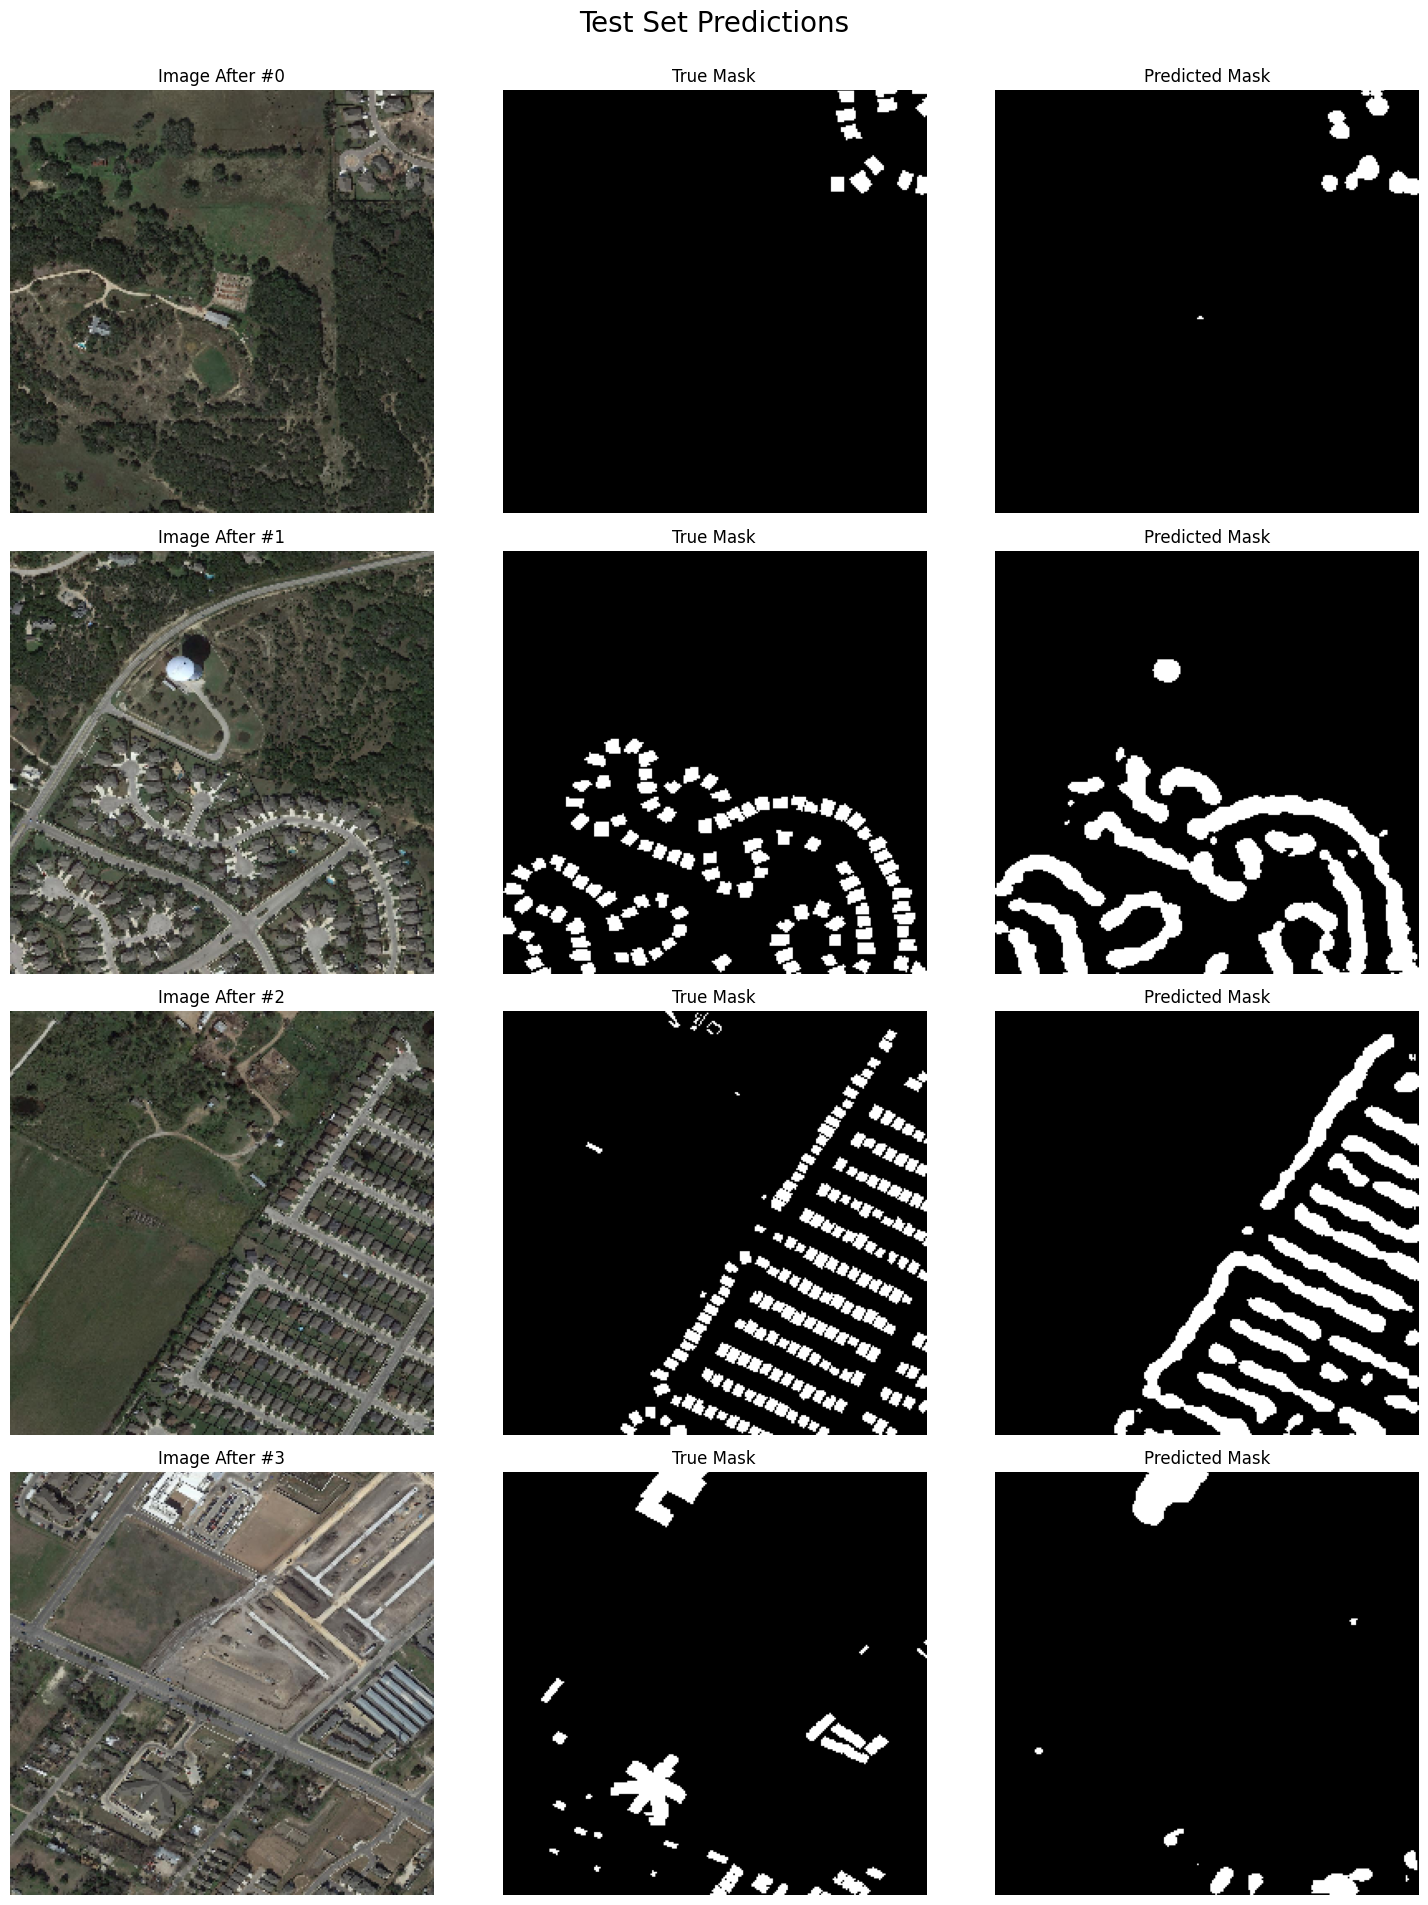

In [66]:
import matplotlib.pyplot as plt

# --- Visualization on a batch from the test set ---
print("\nVisualizing predictions on a sample batch from the test set...")
model.eval() # Ensure model is in evaluation mode
with torch.no_grad():
    # Get a single batch from the test loader
    inputs, true_masks = next(iter(test_loader))
    inputs = inputs.to(device)
    
    # Get model prediction
    pred_logits = model(inputs)
    # Convert logits to a binary mask (0 or 1)
    pred_masks = (torch.sigmoid(pred_logits) > 0.5).float()
    
    # Move tensors to CPU and convert to numpy for plotting
    inputs_np = inputs.cpu().numpy()
    true_masks_np = true_masks.cpu().numpy()
    pred_masks_np = pred_masks.cpu().numpy()

# Plot a few examples from the batch
# Increase the number of rows to see more examples if you like
num_examples_to_plot = 4
fig, axes = plt.subplots(num_examples_to_plot, 3, figsize=(15, 5 * num_examples_to_plot))
fig.suptitle('Test Set Predictions', fontsize=20)

for i in range(num_examples_to_plot):
    # Extract the "after" image for display (channels 3 to 6)
    img_display = inputs_np[i, 3:, :, :].transpose(1, 2, 0)
    
    # Clip values to be in the valid [0,1] range for display
    img_display = np.clip(img_display, 0, 1)
    
    axes[i, 0].imshow(img_display)
    axes[i, 0].set_title(f'Image After #{i}')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(true_masks_np[i].squeeze(), cmap='gray')
    axes[i, 1].set_title('True Mask')
    axes[i, 1].axis('off')

    axes[i, 2].imshow(pred_masks_np[i].squeeze(), cmap='gray')
    axes[i, 2].set_title('Predicted Mask')
    axes[i, 2].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

In [68]:
# --- This cell assumes you have successfully uploaded your kaggle.json API key ---

# Install the Kaggle API client if needed
!pip install -q kaggle

# Create the .kaggle directory and move the API key into it
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# --- Download and Unzip the SECOND Dataset ---
# This command will now succeed because the API key is in place.
!kaggle datasets download -d isaacbrodsky/second-change-detection-dataset -p ./

# Unzip the downloaded file quietly (-q) into a new directory
!unzip -q second-change-detection-dataset.zip -d ./second-dataset
print("SECOND dataset downloaded and unzipped successfully into the 'second-dataset' folder.")

# Let's also run a quick check to see the contents
!ls -l ./second-dataset

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 1734, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'
unzip:  cannot find or open second-change-detection-dataset.zip, second-change-detection-dataset.zip.zip or second-change-detection-dataset.zip.ZIP.
SECOND 